In [31]:
import requests
import pandas as pd
import numpy as np
import datetime 

In [32]:
import matplotlib.pyplot as plt # pyplot
import matplotlib as mpl # matplotlib
%matplotlib inline

mpl.rc('font', family = 'Malgun Gothic') # 한글 설정 (맑은 고딕)
mpl.rc('axes', unicode_minus = False) # 음수 부호 깨지는거 설정

import seaborn as sns # seaborn
import scipy.stats as stats

In [46]:
api_key = 'test_b375f597f54e36891fce7c2f065cd1a95d7a667894ff675e8c0e80d6ff0d63e6efe8d04e6d233bd35cf2fabdeb93fb0d'
headers = {'x-nxopen-api-key': api_key}

In [34]:
match_response = requests.get('https://open.api.nexon.com/static/fconline/meta/matchtype.json', 
                         headers = headers)

print(f"Status Code for division: {match_response.status_code}") 


match_json = match_response.json()
match_df = pd.DataFrame(match_json)
match_df = match_df.rename(columns={'matchtype' : 'matchType'}) 

divison_response = requests.get('https://open.api.nexon.com/static/fconline/meta/division.json', 
                         headers = headers)

print(f"Status Code for division: {divison_response.status_code}") 

division_json = divison_response.json()
division_df = pd.DataFrame(division_json)
division_df = division_df.rename(columns={'divisionId' : 'division'}) 

match_dict = match_df.set_index('matchType')['desc'].to_dict()
division_dict = division_df.set_index('division')['divisionName'].to_dict()

Status Code for division: 200
Status Code for division: 200


In [35]:
match_key = next(k for k, v in match_dict.items() if v == '공식경기')
match_offset = 0
match_limit = 81

attack_position = [i for i in range(9, 20)]
middle_position = [i for i in range(20, 28)]
defense_position = [i for i in range(1, 9)]
goalkeeper_position = [0]

In [62]:
match_params = {'matchtype' : match_key, 
                'offset' : match_offset, 
                'limit' : match_limit}

response_match = requests.get('https://open.api.nexon.com/fconline/v1/match?',  
                    params = match_params, headers = headers)

print(f"Status Code for match: {response_match.status_code}") 

match_id = response_match.json()

match_df = pd.DataFrame(match_id, columns = ['match_ouid'])

Status Code for match: 200


In [63]:
match_user_data = []

new_user_dict = {}

for match_ouid in match_df['match_ouid'] : 
    
    match_detail_params = {'matchid' : match_ouid}

    response_match_detail = requests.get('https://open.api.nexon.com/fconline/v1/match-detail?',  
                        params = match_detail_params, headers = headers)

    if response_match_detail.status_code != 200:
        print(f"Failed to fetch match detail for match_id {match_ouid}")
        continue

    match_detail = response_match_detail.json()
    match_date = match_detail['matchDate']
    
    for match_user in match_detail['matchInfo'] : 
        if match_user['ouid'] not in new_user_dict :
            new_user_dict[match_user['ouid']] = match_user['nickname']
            
        attack_rating = []
        middle_rating = []
        defense_rating = []
        goalkeeper_rating = []
        
        for player in match_user['player'] : 
            if player['spPosition'] == 28 :                             # 후보선수 제외
                continue

            elif player['spPosition'] in attack_position :              # 공격 평점
                attack_rating.append(player['status']['spRating'])

            elif player['spPosition'] in middle_position :              # 미들 평점
                middle_rating.append(player['status']['spRating'])

            elif player['spPosition'] in defense_position :             # 수비 평점
                defense_rating.append(player['status']['spRating'])

            else :                                                      # 골키퍼 평점 
                goalkeeper_rating.append(player['status']['spRating'])
        
        match_user_data.append({
                'match_id': match_ouid,
                'match_date': match_date,
                'user_ouid': match_user['ouid'],
                'user_nickname': match_user['nickname'],
                'match_result':  match_user['matchDetail']['matchResult'] ,
                'match_possession': match_user['matchDetail']['possession'],
                'match_avg_rating': match_user['matchDetail']['averageRating'],
                'match_total_dribble': match_user['matchDetail']['dribble'],
                'match_total_pass_try': match_user['pass']['passTry'],
                'match_total_pass_suc': match_user['pass']['passSuccess'],
                'match_total_shoot': match_user['shoot']['shootTotal'],
                'match_total_shoot_eff': match_user['shoot']['effectiveShootTotal'],
                'match_total_goal': match_user['shoot']['goalTotal'], 
                'attack_position_ratings': round(np.mean(attack_rating), 2),
                'middle_position_ratings': round(np.mean(middle_rating), 2),
                'defense_position_ratings': round(np.mean(defense_rating), 2),
                'goalkeeper_position_ratings': round(np.mean(goalkeeper_rating), 2),

                'match_total_pass_short_try': match_user['pass']['shortPassTry'],
                'match_total_pass_short_suc': match_user['pass']['shortPassSuccess'], 
                'match_total_pass_long_try': match_user['pass']['longPassTry'],
                'match_total_pass_long_suc': match_user['pass']['longPassSuccess'],
                'match_total_pass_through_try': match_user['pass']['throughPassTry'],
                'match_total_pass_through_suc': match_user['pass']['throughPassSuccess'],
                'match_total_shoot_outpenalty_try': match_user['shoot']['shootOutPenalty'],
                'match_total_shoot_outpenalty_suc': match_user['shoot']['goalOutPenalty'],
                'match_total_shoot_inpenalty_try': match_user['shoot']['shootInPenalty'],
                'match_total_shoot_inpenalty_suc': match_user['shoot']['goalInPenalty']
                })

C:\Users\dohyu\miniconda3\envs\project2\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dohyu\miniconda3\envs\project2\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Failed to fetch match detail for match_id 6749e38ae7f3101fe2c38223
Failed to fetch match detail for match_id 6749e38905c0c139c4409444
Failed to fetch match detail for match_id 6749e388899e4f88a31c5885
Failed to fetch match detail for match_id 6749e3843fa4f4188610ea2b
Failed to fetch match detail for match_id 6749e3825bff3863d2e20c24
Failed to fetch match detail for match_id 6749e37e0f9d54945c537e25
Failed to fetch match detail for match_id 6749e37c3c02049a76148ab8
Failed to fetch match detail for match_id 6749e37b3546b81c3aeec51a
Failed to fetch match detail for match_id 6749e37a4cc0c095cb39a44d


In [64]:
match_user_df = pd.DataFrame(match_user_data)

In [65]:
match_user_df

,match_id,match_date,user_ouid,user_nickname,match_result,match_possession,match_avg_rating,match_total_dribble,match_total_pass_try,match_total_pass_suc,...,match_total_pass_short_try,match_total_pass_short_suc,match_total_pass_long_try,match_total_pass_long_suc,match_total_pass_through_try,match_total_pass_through_suc,match_total_shoot_outpenalty_try,match_total_shoot_outpenalty_suc,match_total_shoot_inpenalty_try,match_total_shoot_inpenalty_suc
0,6749e49e25ea093c0ce8280e,2024-11-29T15:59:54,a552f5b5dbe41834cdd9b235edbb3723,축구는전술이다,승,100.0,3.65000,3.0,6.0,5.0,...,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,6749e49e25ea093c0ce8280e,2024-11-29T15:59:54,419ac45b32dcb9009cc8b63aa714ab39,잠실동주먹왕2,오류,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6749e48c5f56ab5e53a33e09,2024-11-29T15:59:01,49d6a0452b000d3377aa7d03c049defe,나는JINSU,패,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6749e47b9ca86ed6243a3e90,2024-11-29T15:58:56,da74dcba2fb02fcab09379a155fbf47b,New2OO2,오류,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6749e47b9ca86ed6243a3e90,2024-11-29T15:58:56,b82a87b52fe9349ec0342e359b0ceca4,GrrrAgain,승,73.0,3.68889,5.0,6.0,5.0,...,3.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,6749e38f5e598cf8bc8358e1,2024-11-29T15:57:53,3c4f10f95d1ea30f25cef42ee7c330d1,요로결석정무,패,37.0,3.17778,14.0,27.0,21.0,...,20.0,18.0,1.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0
116,6749e38f5e598cf8bc8358e1,2024-11-29T15:57:53,02f1b524d367c670fb82d28a84643f01,tkso,승,63.0,4.69444,30.0,48.0,45.0,...,30.0,30.0,5.0,2.0,12.0,12.0,1.0,0.0,6.0,3.0
117,6749e38cea42e1588f84252d,2024-11-29T15:59:29,97422b979dd8ab80b0025076b6eba027,Cantgiveup,승,54.0,4.45556,27.0,41.0,35.0,...,22.0,19.0,4.0,2.0,11.0,11.0,2.0,0.0,5.0,3.0
118,6749e38cea42e1588f84252d,2024-11-29T15:59:29,16923f74e680ca8d15b10730e1674c2e,동네패싸움,패,46.0,3.20556,27.0,39.0,33.0,...,21.0,19.0,2.0,0.0,16.0,14.0,0.0,0.0,0.0,0.0


In [66]:
match_user_df.isna().sum()

match_id                             0
match_date                           0
user_ouid                            0
user_nickname                        0
match_result                         0
match_possession                    36
match_avg_rating                    36
match_total_dribble                 36
match_total_pass_try                36
match_total_pass_suc                36
match_total_shoot                   36
match_total_shoot_eff               36
match_total_goal                    36
attack_position_ratings             36
middle_position_ratings             36
defense_position_ratings            36
goalkeeper_position_ratings         36
match_total_pass_short_try          36
match_total_pass_short_suc          36
match_total_pass_long_try           36
match_total_pass_long_suc           36
match_total_pass_through_try        36
match_total_pass_through_suc        36
match_total_shoot_outpenalty_try    36
match_total_shoot_outpenalty_suc    36
match_total_shoot_inpenal

In [72]:
filtered_match_user_df = match_user_df.dropna()
filtered_match_user_df[50:]

,match_id,match_date,user_ouid,user_nickname,match_result,match_possession,match_avg_rating,match_total_dribble,match_total_pass_try,match_total_pass_suc,...,match_total_pass_short_try,match_total_pass_short_suc,match_total_pass_long_try,match_total_pass_long_suc,match_total_pass_through_try,match_total_pass_through_suc,match_total_shoot_outpenalty_try,match_total_shoot_outpenalty_suc,match_total_shoot_inpenalty_try,match_total_shoot_inpenalty_suc
72,6749e3b5c671f61715eba1a3,2024-11-29T15:57:57,8ba08e0b273f5a00b4304cac8dcafdd1,수쿠마미즈시,승,61.0,4.46667,15.0,21.0,20.0,...,18.0,18.0,0.0,0.0,3.0,2.0,2.0,1.0,3.0,2.0
75,6749e3b51bbc533375eb9ed1,2024-11-29T15:59:37,131fa8c48f30253330924c32243f7d57,맹구콧물훔치기1,패,50.0,3.10000,31.0,48.0,41.0,...,37.0,33.0,2.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0
76,6749e3b366b923c267816e71,2024-11-29T15:59:21,bc5e568723e81002009ff6d87c35ddb8,올패siu,패,42.0,3.32778,20.0,22.0,21.0,...,9.0,8.0,1.0,1.0,12.0,12.0,2.0,0.0,2.0,0.0
77,6749e3b366b923c267816e71,2024-11-29T15:59:21,a53d3ab5ac1833d35b5f2a6323e7c171,OHJlwoo,승,58.0,4.41111,25.0,37.0,34.0,...,10.0,10.0,3.0,1.0,23.0,23.0,1.0,0.0,3.0,3.0
78,6749e3b1fb2d0fc946c8c776,2024-11-29T15:59:46,409f798c75a5bf19c03e1be26d3e5064,모두행복하긋나,패,40.0,3.36111,23.0,31.0,25.0,...,16.0,14.0,4.0,2.0,10.0,8.0,0.0,0.0,2.0,1.0
79,6749e3ae1c173738ef1f0c72,2024-11-29T15:58:26,66a10920c0c7623179b71b57a493a765,후아,패,46.0,3.46111,22.0,41.0,34.0,...,37.0,31.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0
82,6749e3ad06f49c703ec69b02,2024-11-29T15:58:50,2b7d210d77cb716d51f3758fcff5f84d,좌파우파메카노,승,58.0,4.40000,30.0,46.0,41.0,...,36.0,34.0,0.0,0.0,7.0,5.0,1.0,0.0,4.0,3.0
84,6749e3a5b099c3800d5d9113,2024-11-29T15:58:58,ea64449ebbfd61d616dbd6be89a63c95,CIVALNEN,승,52.0,4.17778,35.0,57.0,50.0,...,45.0,41.0,1.0,0.0,11.0,9.0,4.0,0.0,1.0,1.0
86,6749e3a5546c3a2968d00b82,2024-11-29T15:55:32,922d9f1d1500298fbc8ca72aa350a6aa,K폭콜,승,66.0,4.61111,11.0,23.0,22.0,...,15.0,15.0,3.0,2.0,5.0,5.0,1.0,0.0,4.0,3.0
87,6749e3a44e62ee2e10651ac5,2024-11-29T15:59:18,3b21cd894dbb4f31d8eb977727b303e3,지네딘고명,승,59.0,4.54444,35.0,54.0,49.0,...,35.0,34.0,5.0,2.0,13.0,12.0,1.0,1.0,2.0,2.0


In [68]:
new_user_dict

{'a552f5b5dbe41834cdd9b235edbb3723': '축구는전술이다',
 '419ac45b32dcb9009cc8b63aa714ab39': '잠실동주먹왕2',
 '49d6a0452b000d3377aa7d03c049defe': '나는JINSU',
 'da74dcba2fb02fcab09379a155fbf47b': 'New2OO2',
 'b82a87b52fe9349ec0342e359b0ceca4': 'GrrrAgain',
 '81619d87e999dea1a1905f21643319db': '식권받아가세요',
 '7bdc6cee450c98ccf9a23a7b9e8970a9': '서소민',
 'c39198929a184c522be44ba0d0cf4858': '재돌이와아이들',
 '42951877b36235b555973ccfa89d0e65': '정우수',
 '09d1997ed8a4a7b3ade150bd22001476': '헤이으응',
 '162c88e92e193e2a1347c034ea3f6567': '메갓호잣',
 '7c4af773f4b42663965c7b986f9910c0': '춘디',
 'f3bf3783f13d87002cf18eefc7dbc06b': '효주잉',
 '53c934f1c606f630be14ea80b514e022': 'GC막걸리',
 '61e374dabe085228e5ec1ca67a776f3a': 'Gunnnner',
 '55bd2483c3ea15c28df2b37de83c3f4f': '환요',
 '2f7198e7977196ddf568cfc765803d5a': '닉뺏긴코로나',
 '9010852e4a4155a3ee49edbb6106f211': '날두형은잘못없다',
 'c62a0127c11348431d706a668abbef1b': '판다기하니',
 '0f5b75778a65107e846d450d9a47488a': '몽구돈까스',
 '8213bd2c658253b29bb86f9900808712': 'VfL볼프스브르크',
 'c20b261309e7b97b041

###################################################################################################################

In [13]:
# mysql> create table test (
#    -> id bigint not null,
#    -> seq bigint not null,
#    -> primary key(id, seq)
#    -> );
# Query OK, 0 rows affected (0.01 sec)

In [14]:
from sqlalchemy import create_engine, text
import pandas as pd

db_conn = {
     "user": "root",
     "password": "Dhyoon96!",
     "host": "127.0.0.1",
     "database": "side_proj_FCO"
 }

db_engine = "mysql+pymysql://%s:%s@%s/%s" % (
    db_conn["user"],
    db_conn["password"],
    db_conn["host"],
    db_conn["database"]
)

engine = create_engine(db_engine, echo=True)

In [15]:
create_match_user_table_query = """
    CREATE TABLE IF NOT EXISTS match_user (
        match_id VARCHAR(40),         
        user_ouid VARCHAR(40),        
        user_nickname VARCHAR(50),      
        match_result VARCHAR(5),                             
        match_possession INT,                               
        match_avg_rating FLOAT,                              
        match_total_dribble INT,                              
        match_total_pass_try INT,                             
        match_total_pass_suc INT,                             
        match_total_shoot INT,                                
        match_total_shoot_eff INT,                            
        match_total_goal INT,         
        attack_position_ratings FLOAT,
        middle_position_ratings FLOAT,
        defense_position_ratings FLOAT,
        goalkeeper_position_ratings FLOAT,                       
        match_total_pass_short_try INT,
        match_total_pass_short_suc INT,
        match_total_pass_long_try INT,
        match_total_pass_long_suc INT,
        match_total_pass_through_try INT,
        match_total_pass_through_suc INT,
        match_total_shoot_outpenalty_try INT,
        match_total_shoot_outpenalty_suc INT,
        match_total_shoot_inpenalty_try INT,
        match_total_shoot_inpenalty_suc INT, 
        
        PRIMARY KEY (match_id, user_ouid)
    );   
    """

insert_match_user_table_query = """
    INSERT IGNORE INTO match_user (match_id, user_ouid, user_nickname, match_result, match_possession, match_avg_rating, 
                                   match_total_dribble, match_total_pass_try, match_total_pass_suc, match_total_shoot, 
                                   match_total_shoot_eff, match_total_goal, 
                                   attack_position_ratings, middle_position_ratings, defense_position_ratings, goalkeeper_position_ratings,
                                   match_total_pass_short_try, match_total_pass_short_suc, 
                                   match_total_pass_long_try, match_total_pass_long_suc, 
                                   match_total_pass_through_try, match_total_pass_through_suc, 
                                   match_total_shoot_outpenalty_try, match_total_shoot_outpenalty_suc, 
                                   match_total_shoot_inpenalty_try, match_total_shoot_inpenalty_suc)
    VALUES (:match_id, :user_ouid, :user_nickname, :match_result, :match_possession, :match_avg_rating, 
            :match_total_dribble, :match_total_pass_try, :match_total_pass_suc, :match_total_shoot, 
            :match_total_shoot_eff, :match_total_goal,
            :attack_position_ratings, :middle_position_ratings, :defense_position_ratings, :goalkeeper_position_ratings,
            :match_total_pass_short_try, :match_total_pass_short_suc, 
            :match_total_pass_long_try, :match_total_pass_long_suc, 
            :match_total_pass_through_try, :match_total_pass_through_suc, 
            :match_total_shoot_outpenalty_try, :match_total_shoot_outpenalty_suc, 
            :match_total_shoot_inpenalty_try, :match_total_shoot_inpenalty_suc);
            """

create_user_metadata_table_query = """
    CREATE TABLE IF NOT EXISTS user_metadata (
        user_ouid VARCHAR(40) PRIMARY KEY,
        user_nickname VARCHAR(50) NOT NULL);
    """

insert_user_metadata_table_query = """
    INSERT IGNORE INTO user_metadata (user_ouid, user_nickname)
    VALUES (:user_ouid, :user_nickname);    
    """

In [16]:
with engine.connect() as connection:
    trans = connection.begin()  # 트랜잭션 시작
    
    try:
        connection.execute(text(create_match_user_table_query))
        connection.execute(text(create_user_metadata_table_query))

        try:
            for new_user_ouid, new_user_nickname in new_user_dict.items() : 
                connection.execute(
                    text(insert_user_metadata_table_query),
                    {'user_ouid': new_user_ouid, 'user_nickname': new_user_nickname}
                )
            for index, row in filtered_match_user_df.iterrows():
                connection.execute(text(insert_match_user_table_query), {
                    'match_id': row['match_id'],
                    'user_ouid': row['user_ouid'],
                    'user_nickname': row['user_nickname'],
                    'match_result': row['match_result'],
                    'match_possession': row['match_possession'],
                    'match_avg_rating': row['match_avg_rating'],
                    'match_total_dribble': row['match_total_dribble'],
                    'match_total_pass_try': row['match_total_pass_try'],
                    'match_total_pass_suc': row['match_total_pass_suc'],
                    'match_total_shoot': row['match_total_shoot'],
                    'match_total_shoot_eff': row['match_total_shoot_eff'],
                    'match_total_goal': row['match_total_goal'], 
                    'attack_position_ratings': row['attack_position_ratings'],
                    'middle_position_ratings': row['middle_position_ratings'],
                    'defense_position_ratings': row['defense_position_ratings'],
                    'goalkeeper_position_ratings': row['goalkeeper_position_ratings'],
                    'match_total_pass_short_try': row['match_total_pass_short_try'],
                    'match_total_pass_short_suc': row['match_total_pass_short_suc'],
                    'match_total_pass_long_try': row['match_total_pass_long_try'],
                    'match_total_pass_long_suc': row['match_total_pass_long_suc'],
                    'match_total_pass_through_try': row['match_total_pass_through_try'],
                    'match_total_pass_through_suc': row['match_total_pass_through_suc'],
                    'match_total_shoot_outpenalty_try': row['match_total_shoot_outpenalty_try'],
                    'match_total_shoot_outpenalty_suc': row['match_total_shoot_outpenalty_suc'],
                    'match_total_shoot_inpenalty_try': row['match_total_shoot_inpenalty_try'],
                    'match_total_shoot_inpenalty_suc': row['match_total_shoot_inpenalty_suc']
                    })

        except Exception as insert_e:
            print(f"데이터 추가 중 오류가 발생했습니다: {insert_e}")
            trans.rollback()  
            raise  # 오류를 다시 발생시켜 외부 `except`에서 처리 가능하게 함
        
        trans.commit() 
        
    except Exception as create_e:
        print(f"테이블 생성 중 오류가 발생했습니다: {create_e}")
        trans.rollback()

2024-11-29 23:49:08,626 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-11-29 23:49:08,627 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-29 23:49:08,629 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-11-29 23:49:08,630 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-29 23:49:08,631 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-11-29 23:49:08,632 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-29 23:49:08,634 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-11-29 23:49:08,635 INFO sqlalchemy.engine.Engine 
    CREATE TABLE IF NOT EXISTS match_user (
        match_id VARCHAR(40),         
        user_ouid VARCHAR(40),        
        user_nickname VARCHAR(50),      
        match_result VARCHAR(5),                             
        match_possession INT,                               
        match_avg_rating FLOAT,                              
        match_total_dribble INT,                              
        match_total_pass_try INT

In [17]:
engine.dispose()

---

---

# Vanila Model (RandomForestClassifier)

In [1]:
from sqlalchemy import create_engine, text
import pandas as pd

db_conn = {
     "user": "root",
     "password": "Dhyoon96!",
     "host": "127.0.0.1",
     "database": "side_proj_FCO"
 }

db_engine = "mysql+pymysql://%s:%s@%s/%s" % (
    db_conn["user"],
    db_conn["password"],
    db_conn["host"],
    db_conn["database"]
)

engine = create_engine(db_engine, echo=True)

In [2]:
df_query = 'SELECT * FROM match_user'
df1 = pd.read_sql(df_query, con = engine)

2024-11-30 23:10:41,940 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-11-30 23:10:41,940 INFO sqlalchemy.engine.Engine [raw sql] {}


2024-11-30 23:10:41,942 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-11-30 23:10:41,943 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-30 23:10:41,946 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-11-30 23:10:41,947 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-30 23:10:41,948 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-11-30 23:10:41,949 INFO sqlalchemy.engine.Engine DESCRIBE `side_proj_fco`.`SELECT * FROM match_user`
2024-11-30 23:10:41,949 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-30 23:10:41,952 INFO sqlalchemy.engine.Engine SELECT * FROM match_user
2024-11-30 23:10:41,952 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-11-30 23:10:42,004 INFO sqlalchemy.engine.Engine ROLLBACK


In [3]:
df1

,match_id,user_ouid,user_nickname,match_result,match_possession,match_avg_rating,match_total_dribble,match_total_pass_try,match_total_pass_suc,match_total_shoot,...,match_total_pass_short_try,match_total_pass_short_suc,match_total_pass_long_try,match_total_pass_long_suc,match_total_pass_through_try,match_total_pass_through_suc,match_total_shoot_outpenalty_try,match_total_shoot_outpenalty_suc,match_total_shoot_inpenalty_try,match_total_shoot_inpenalty_suc
0,67418a50fcfb86525b068dc9,c5bd2d238afff4775b5e6bc5c928e31c,SaddIerS3,승,70,4.08333,19,19,17,4,...,12,12,1,0,6,5,2,1,2,0
1,67418a525b7f6b04d21d13d4,a49aaacc626c90bca37e175eb31ec288,A헤가오,승,59,4.17222,17,32,28,4,...,26,23,0,0,6,5,2,1,1,1
2,67418a563909e504f56f8222,623d56892e95056759904c52507a366a,대북중1짱,패,47,3.76111,21,25,23,0,...,12,12,0,0,13,11,0,0,0,0
3,67418a58060e19029147892c,0db87e3296072311b38a1c19fc243939,LanderSSG,승,53,4.14444,23,32,29,1,...,24,23,2,0,6,6,0,0,1,1
4,67418a5b49725df11f881dad,48d376ea55efee991a7155369a1fa951,호날두lol,승,48,4.45556,32,44,44,7,...,40,40,1,1,2,2,3,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,674afdbf8e3406412d3e54df,3f10a7eb8b9b187345f4dc3462fe5f3d,100억하나만,승,10,3.84444,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1505,674afdc4275c0dce61201e15,81c6acd9f7d584a948bee59d599c873e,피데스,패,29,3.43889,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1506,674afdc4275c0dce61201e15,ab4f611640420ca0e918d8a7315f563b,cycycycy,승,71,3.98333,8,9,9,2,...,7,7,0,0,2,2,0,0,2,1
1507,674afdcc4e7e0471039cb8df,3c8993f0a2a94a1c5226952c2356c5ed,뚱덕빠,패,56,4.41667,9,12,12,2,...,11,11,0,0,1,1,1,1,1,0


In [4]:
position_ratings_col = ['attack_position_ratings', 
                        'middle_position_ratings', 
                        'defense_position_ratings', 
                        'goalkeeper_position_ratings']

In [5]:
df2 = df1.drop(columns = ['match_id', 'user_ouid', 'user_nickname', 
                          'match_avg_rating', 'match_total_goal',
                          'match_total_dribble', 'match_total_pass_try', 'match_total_pass_suc',
                          'match_total_shoot', 'match_total_shoot_eff', 
                          'match_total_pass_short_suc', 
                          'match_total_pass_through_suc', 
                          'match_total_pass_long_suc', 
                          'match_total_shoot_outpenalty_suc', 
                          'match_total_shoot_inpenalty_suc']
                          + position_ratings_col)

In [6]:
df2

,match_result,match_possession,match_total_pass_short_try,match_total_pass_long_try,match_total_pass_through_try,match_total_shoot_outpenalty_try,match_total_shoot_inpenalty_try
0,승,70,12,1,6,2,2
1,승,59,26,0,6,2,1
2,패,47,12,0,13,0,0
3,승,53,24,2,6,0,1
4,승,48,40,1,2,3,4
...,...,...,...,...,...,...,...
1504,승,10,0,1,0,0,0
1505,패,29,0,0,0,0,0
1506,승,71,7,0,2,0,2
1507,패,56,11,0,1,1,1


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 특성과 타겟 분리
X_1 = df2.drop('match_result', axis = 1)
y_1 = df2['match_result']

# 학습/테스트 데이터 분할
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.2, random_state = 42, stratify = y_1)

scaler = MinMaxScaler()
X_1_train_scaled = scaler.fit_transform(X_1_train)
X_1_test_scaled = scaler.transform(X_1_test)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

# 모델 초기화 및 학습
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(X_1_train_scaled, y_1_train)

# 예측
y_1_pred = model_1.predict(X_1_test_scaled)

# 평가
print("Accuracy:", accuracy_score(y_1_test, y_1_pred))
print("\nClassification Report:\n", classification_report(y_1_test, y_1_pred))

Accuracy: 0.8435114503816794

Classification Report:
               precision    recall  f1-score   support

           승       0.84      0.88      0.86       139
           패       0.85      0.80      0.83       123

    accuracy                           0.84       262
   macro avg       0.84      0.84      0.84       262
weighted avg       0.84      0.84      0.84       262



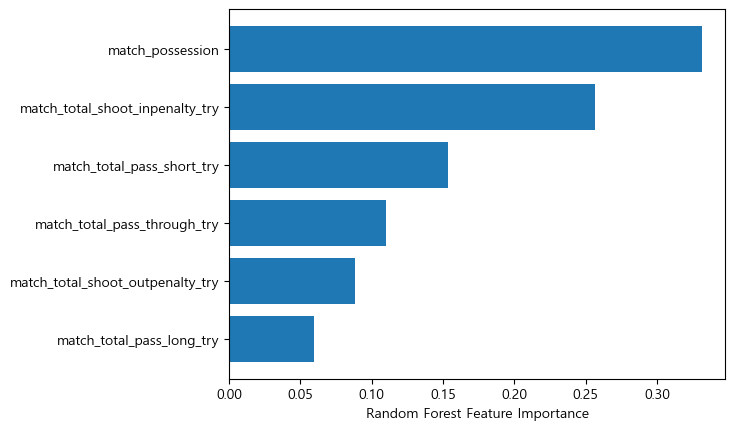

In [25]:
feature_importance = model_1.feature_importances_
sorted_idx = feature_importance.argsort()

plt.barh(X_1.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

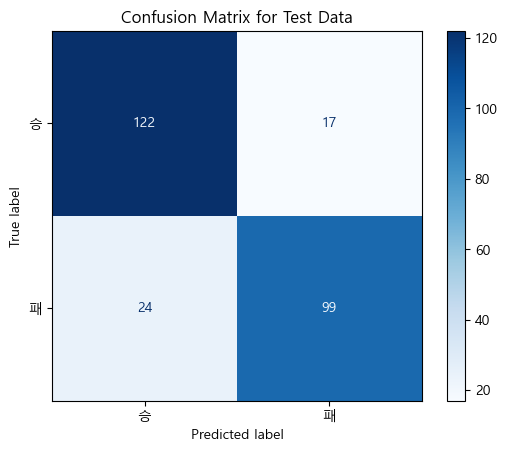

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 계산
cm = confusion_matrix(y_1_test, y_1_pred)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Test Data")
plt.show()

---

---

Fold 1 Validation Accuracy: 0.8230
Fold 2 Validation Accuracy: 0.8278
Fold 3 Validation Accuracy: 0.8086
Fold 4 Validation Accuracy: 0.8373
Fold 5 Validation Accuracy: 0.8565

Mean Validation Accuracy across folds: 0.8306

Test Accuracy: 0.8282442748091603

Classification Report on Test Set:
               precision    recall  f1-score   support

           승       0.82      0.86      0.84       139
           패       0.84      0.79      0.81       123

    accuracy                           0.83       262
   macro avg       0.83      0.83      0.83       262
weighted avg       0.83      0.83      0.83       262



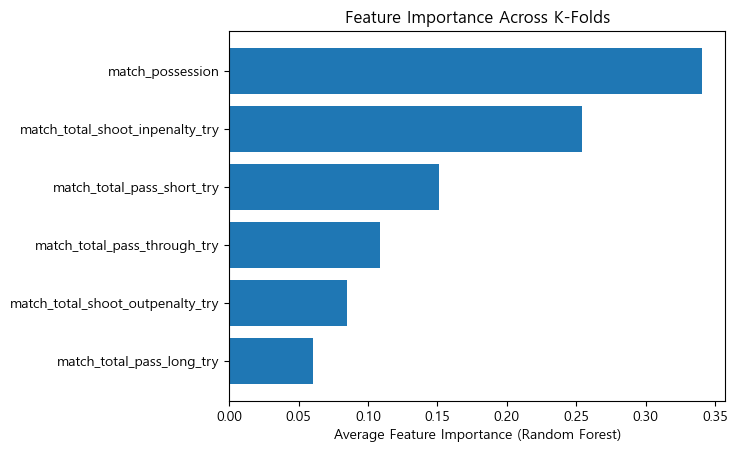

In [27]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 특성과 타겟 분리
X_2 = df2.drop('match_result', axis=1)
y_2 = df2['match_result']

# 테스트 데이터 분리 (최종 평가용)
X_2_temp, X_2_test, y_2_temp, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42, stratify=y_1)

# K-Fold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
feature_importance_accumulated = np.zeros(X_2.shape[1])

# 모델 초기화
model_2 = RandomForestClassifier(random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_2_temp, y_2_temp), 1):
    # Train / Validation Split
    X_2_train, X_2_val = X_2_temp.iloc[train_idx], X_2_temp.iloc[val_idx]
    y_2_train, y_2_val = y_2_temp.iloc[train_idx], y_2_temp.iloc[val_idx]
    
    # 데이터 스케일링
    scaler = MinMaxScaler()
    X_2_train_scaled = scaler.fit_transform(X_2_train)
    X_2_val_scaled = scaler.transform(X_2_val)
    
    # 모델 학습
    model_2.fit(X_2_train_scaled, y_2_train)
    
    # 검증 데이터 평가
    y_2_val_pred = model_2.predict(X_2_val_scaled)
    val_accuracy = accuracy_score(y_2_val, y_2_val_pred)
    fold_accuracies.append(val_accuracy)
    
    print(f"Fold {fold} Validation Accuracy: {val_accuracy:.4f}")
    
    # 피처 중요도 누적
    feature_importance_accumulated += model_2.feature_importances_

# 평균 검증 정확도
print(f"\nMean Validation Accuracy across folds: {np.mean(fold_accuracies):.4f}")

# 최종 테스트 데이터 평가
X_2_test_scaled = scaler.transform(X_2_test)
y_2_test_pred = model_2.predict(X_2_test_scaled)

print("\nTest Accuracy:", accuracy_score(y_2_test, y_2_test_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_2_test, y_2_test_pred))

# 피처 중요도 시각화
feature_importance_avg = feature_importance_accumulated / kf.get_n_splits()
sorted_idx = feature_importance_avg.argsort()

plt.barh(X_2.columns[sorted_idx], feature_importance_avg[sorted_idx])
plt.xlabel("Average Feature Importance (Random Forest)")
plt.title("Feature Importance Across K-Folds")
plt.show()

In [28]:
import pandas as pd

# 실제 값과 예측 값을 데이터프레임으로 저장
test_results = pd.DataFrame({
    'Actual': y_2_test.values,
    'Predicted': y_2_test_pred
})

# 결과 확인
print(test_results)  # 상위 10개 데이터 출력

    Actual Predicted
0        패         패
1        패         패
2        승         승
3        승         승
4        패         승
..     ...       ...
257      승         승
258      승         승
259      승         승
260      승         승
261      패         패

[262 rows x 2 columns]


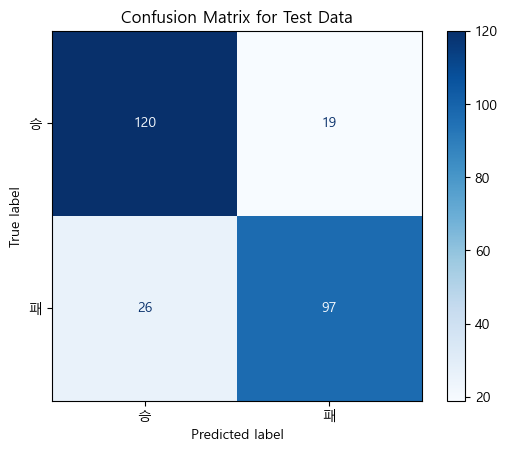

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 계산
cm = confusion_matrix(y_2_test, y_2_test_pred)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_2.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Test Data")
plt.show()

In [30]:
# 클래스 분포 확인
print("Training Data Distribution:")
print(y_2_train.value_counts(normalize=True))

print("\nTest Data Distribution:")
print(y_2_test.value_counts(normalize=True))

Training Data Distribution:
match_result
승    0.532297
패    0.467703
Name: proportion, dtype: float64

Test Data Distribution:
match_result
승    0.530534
패    0.469466
Name: proportion, dtype: float64
